In this notebook we show how to use the new deepymod code and phimal utilities to load data and perform data analysis:

In [1]:
import numpy as np
import pandas as pd
import torch
import time
from scipy.io import loadmat

from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.training import train_dynamic_logprob_scaled
from sklearn.linear_model import LassoLarsIC, LarsCV
from DeePyMoD_SBL.deepymod_torch.output import Tensorboard, progress
from DeePyMoD_SBL.deepymod_torch.losses import reg_loss, mse_loss, l1_loss
from DeePyMoD_SBL.deepymod_torch.sparsity import scaling, threshold
from numpy import pi

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from phimal_utilities.analysis import load_tensorboard

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time
%load_ext autoreload

%autoreload 2

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

# Making data

In [2]:
data = loadmat('kuramoto_sivishinky.mat')
print('Shape of grid:', data['x'].shape)

Shape of grid: (1024, 1)


In [3]:
t = data['tt']
x=data['x']
uu= data['uu']
x_grid,t_grid = np.meshgrid(x,t,indexing='ij')

In [4]:
uu[:,:50].shape

(1024, 50)

In [5]:
x_grid.shape

(1024, 251)

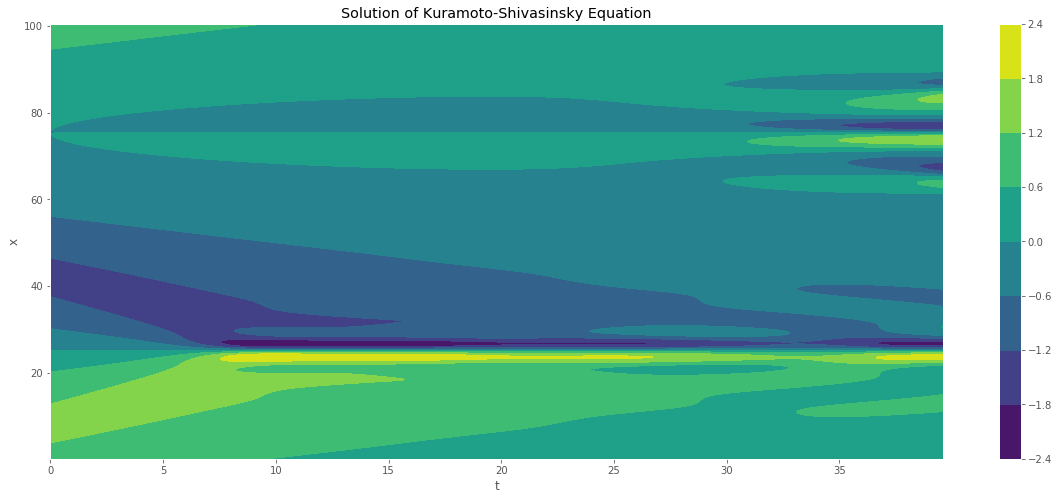

In [6]:
plt.figure(figsize=(20,8))

plt.contourf(t_grid[:,:100],x_grid[:,:100],uu[:,:100])
plt.xlabel('t')
plt.ylabel('x')
plt.title('Solution of Kuramoto-Shivasinsky Equation')
plt.colorbar()


In [7]:
uu[:,50]

array([0.41624991, 0.41931985, 0.42238844, ..., 0.40704936, 0.41011298,
       0.41318038])

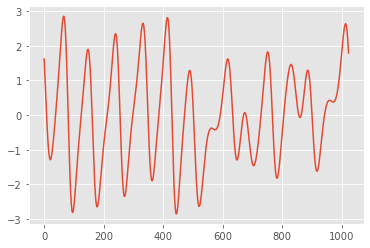

In [8]:
plt.plot(uu[:,134])

Create a dataset by giving your solution to the object and its parameters (make sure they're named)

In [9]:
x_grid = x_grid[:,:100]
t_grid = t_grid[:,:100]
uu = uu[:,:100]

In [10]:
X = np.transpose((t_grid.flatten(),x_grid.flatten()))
y = uu.reshape((uu.size, 1))

In [11]:
print(X.shape, y.shape)

(102400, 2) (102400, 1)


In [12]:
noise_level = 0.0
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)
number_of_samples = 10000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

# Running deepmod

Now we show how to use the new deepmod. We first define which sparsity estimator we want to use. All estimators from scikitlearn are fine. set fit_intercept to false as that term is in our model.

In [13]:
estimator = LarsCV(fit_intercept=False)

Then we define the config and build the model as always:

In [14]:
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20, 20,20, 20], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order': 1, 'diff_order': 4}, 'sparsity_estimator': estimator}
model = DeepModDynamic(**config)


#In the future, I want to change the api so that we would do the following:
'''
function_approximator = network(n_in=2, hidden_dims=[30, 30, 30, 30, 30], n_out=1)
library = Library(function=library_1D_in, poly_order=2, deriv_order=2)
sparse_estimator = Estimator(fit_intercept=False)

model = DeepMoD(function_approximator, library, sparse_estimator)
'''
# main reason is not to get a massive config dictionary which is not very clear. This would also be super flexible.

'\nfunction_approximator = network(n_in=2, hidden_dims=[30, 30, 30, 30, 30], n_out=1)\nlibrary = Library(function=library_1D_in, poly_order=2, deriv_order=2)\nsparse_estimator = Estimator(fit_intercept=False)\n\nmodel = DeepMoD(function_approximator, library, sparse_estimator)\n'

Define the optimizer:

In [15]:
optimizer = torch.optim.Adam(model.network_parameters(),betas=(0.99,0.99), amsgrad=True)

And train for 15k:. We start the sparsity update after 5000 iterations so we have a good estimate of the data and update it every 200 iterations after:

In [16]:
# Defining training function
def train(model, data, target, optimizer, max_iterations, loss_func_args, log_dir=None):
    start_time = time.time()
    number_of_terms = [coeff_vec.shape[0] for coeff_vec in model(data)[3]]
    board = Tensorboard(number_of_terms, log_dir)
    
    # Training
    print('| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |')
    for iteration in torch.arange(0, max_iterations + 1):
        # Calculating prediction and library and scaling
        prediction, time_deriv_list, sparse_theta_list, coeff_vector_list, theta = model(data)
        coeff_vector_scaled_list = scaling(coeff_vector_list, sparse_theta_list, time_deriv_list) 
        
        # Calculating loss
        loss_mse = mse_loss(prediction, target)
        loss_reg = reg_loss(time_deriv_list, sparse_theta_list, coeff_vector_list)
        loss_ll = torch.log(2 * pi * loss_mse)
        loss_ll_fit = torch.log(2 * pi * loss_mse) + loss_reg / loss_mse
        loss = torch.sum(loss_ll) + torch.sum(loss_ll_fit)
        
        # Writing
        if iteration % 100 == 0:
            # Write progress to command line
            progress(iteration, start_time, max_iterations, loss.item(), torch.sum(loss_mse).item(), torch.sum(loss_reg).item(), torch.sum(loss_ll).item())
            
            # Calculate error for theta
            
            # Write to tensorboard
            board.write(iteration, loss, loss_mse, loss_reg, loss_ll, coeff_vector_list, coeff_vector_scaled_list)

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    board.close()


In [17]:
train(model, X_train, y_train, optimizer, 100000, loss_func_args={'start_sparsity_update': 3000, 'sparsity_update_period': 250})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
     100000    100.00%               0s   -8.72e+00   1.05e-03   1.39e-03   -5.02e+00 